Load and Prepare the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new.csv")

# Define the target variable and numeric columns
target = 'fgp_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

# Specify the wavenumber regions to focus on
focus_regions = [
    (2996, 3016), (2943, 2963), (2912, 2932), (2843, 2863),
    (1490, 2010), (1455, 1475), (1408, 1428), (1368, 1388),
    (1225, 1245), (1150, 1170), (1106, 1126), (1088, 1108),
    (990, 920), (712, 732)
]

# Convert column names to float
numeric_cols_df_0_float = [float(col) for col in numeric_cols_df_0]

# Flatten the list of regions to get all columns in the specified regions
columns_to_focus = []
for start, end in focus_regions:
    columns_to_focus.extend([col for col in numeric_cols_df_0_float if start <= col <= end])

# Convert back to string for DataFrame indexing and ensure columns are present in the DataFrame
columns_to_focus = [str(col) for col in columns_to_focus if str(col) in df_0.columns]


Train RandomForest Model and Get Feature Importances

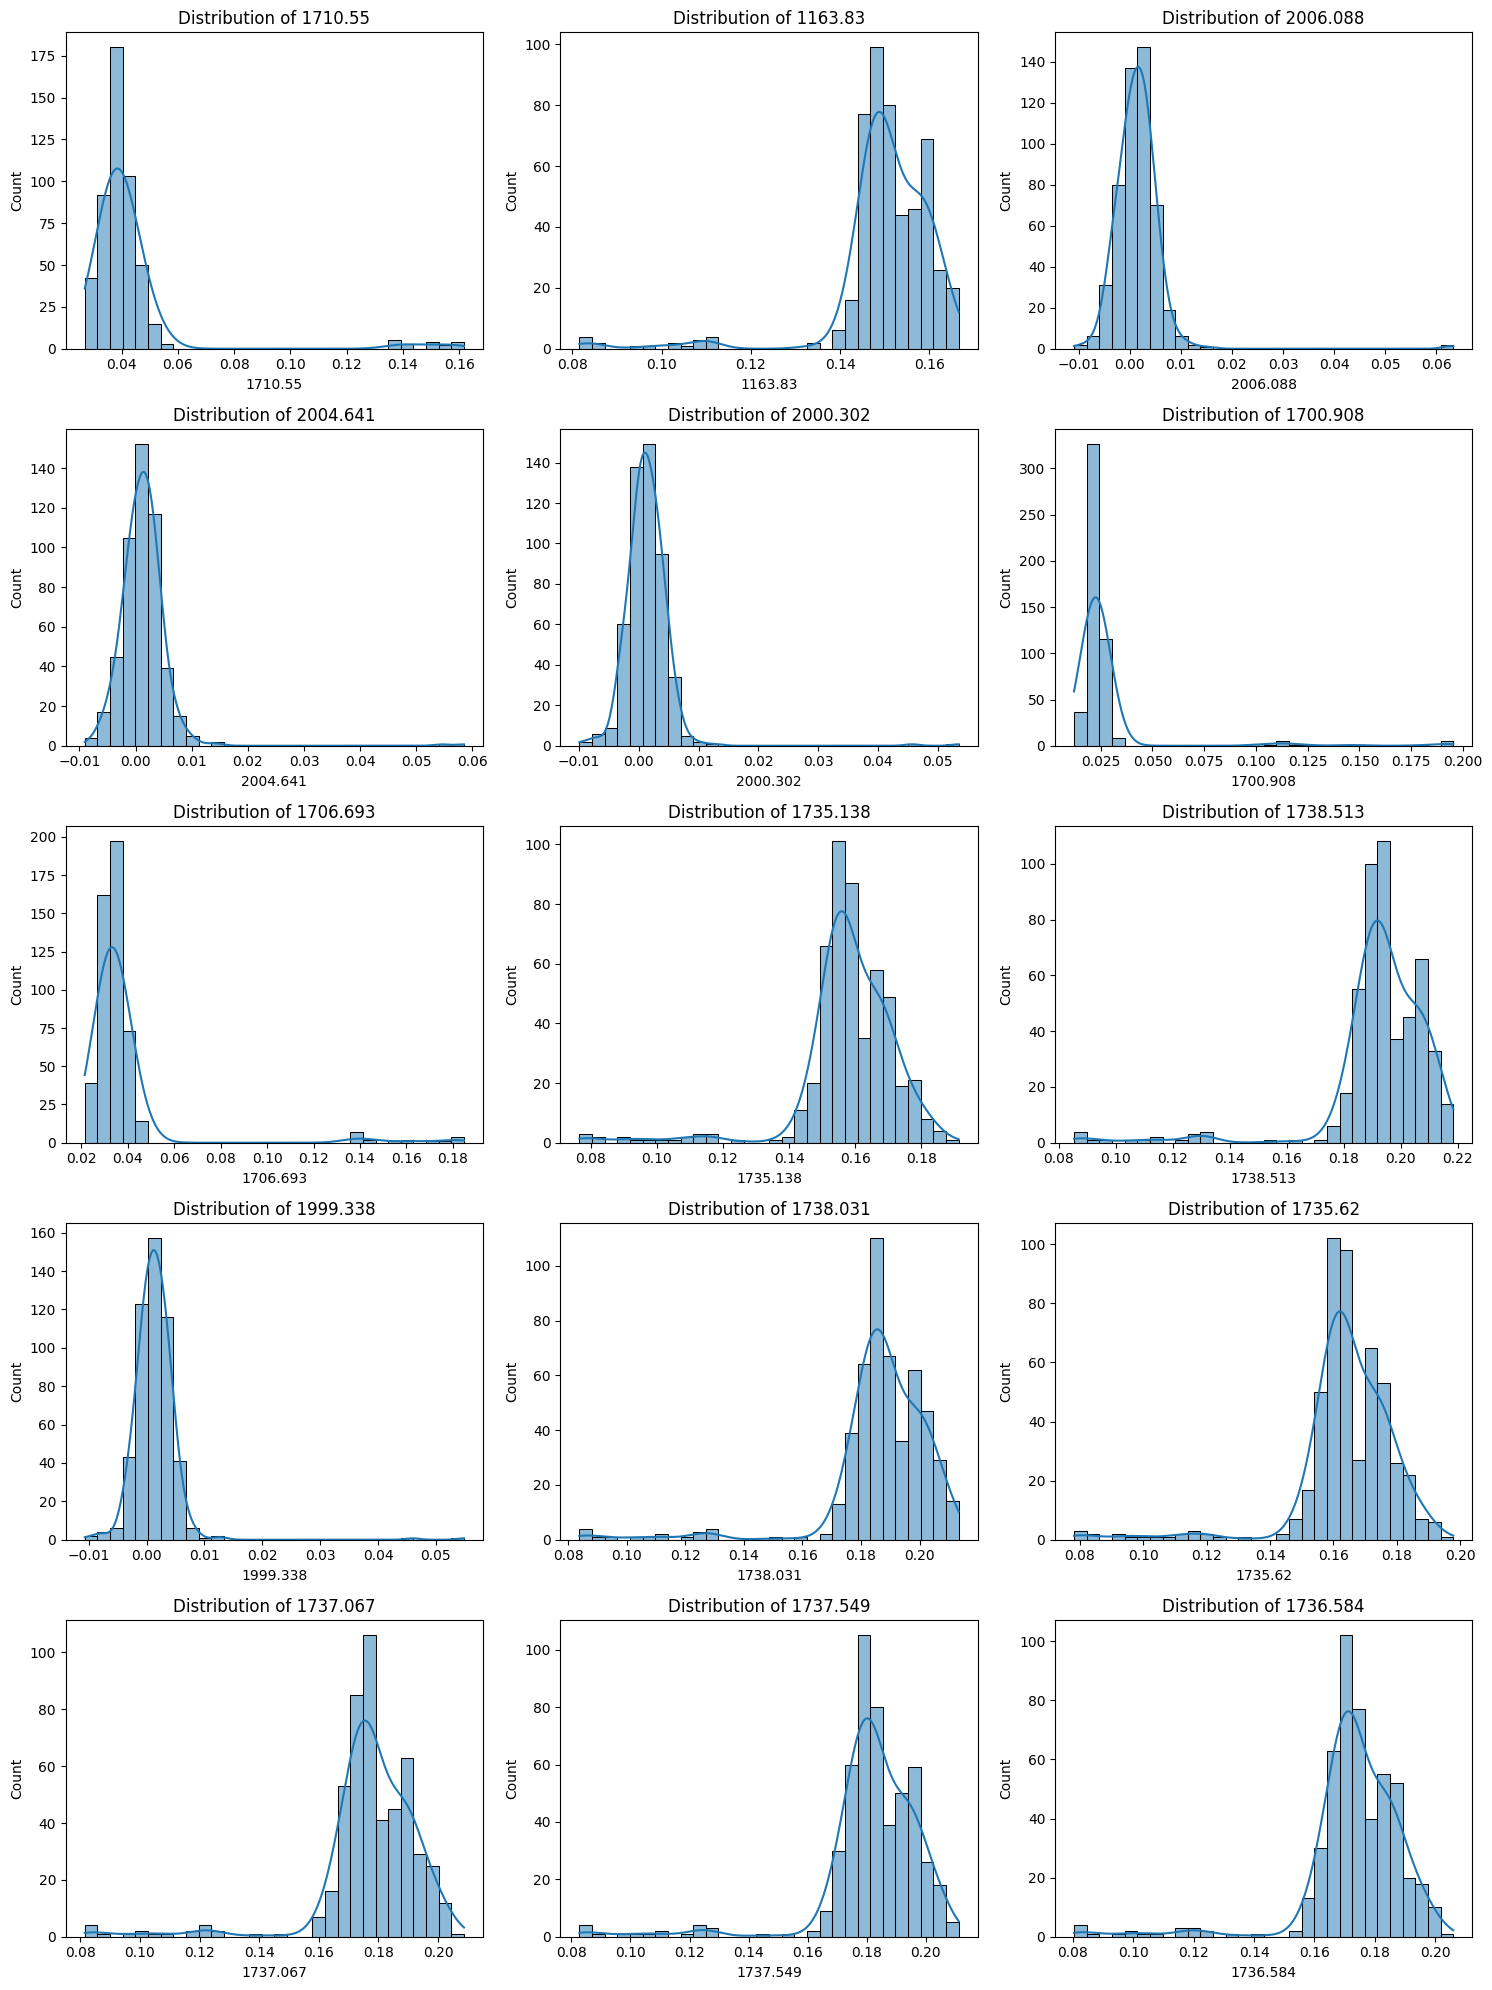

In [2]:
# Train a RandomForest model to get feature importances
X = df_0[columns_to_focus]
y = df_0[target]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

# Plot the distribution of the top 15 most important features
plt.figure(figsize=(15, 20))
for i, idx in enumerate(indices):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_0[columns_to_focus[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {columns_to_focus[idx]}')
plt.tight_layout()
plt.show()


Remove Outliers Using Z-score

Original Data Shape: (503, 6958)
Cleaned Data Shape: (483, 6958)


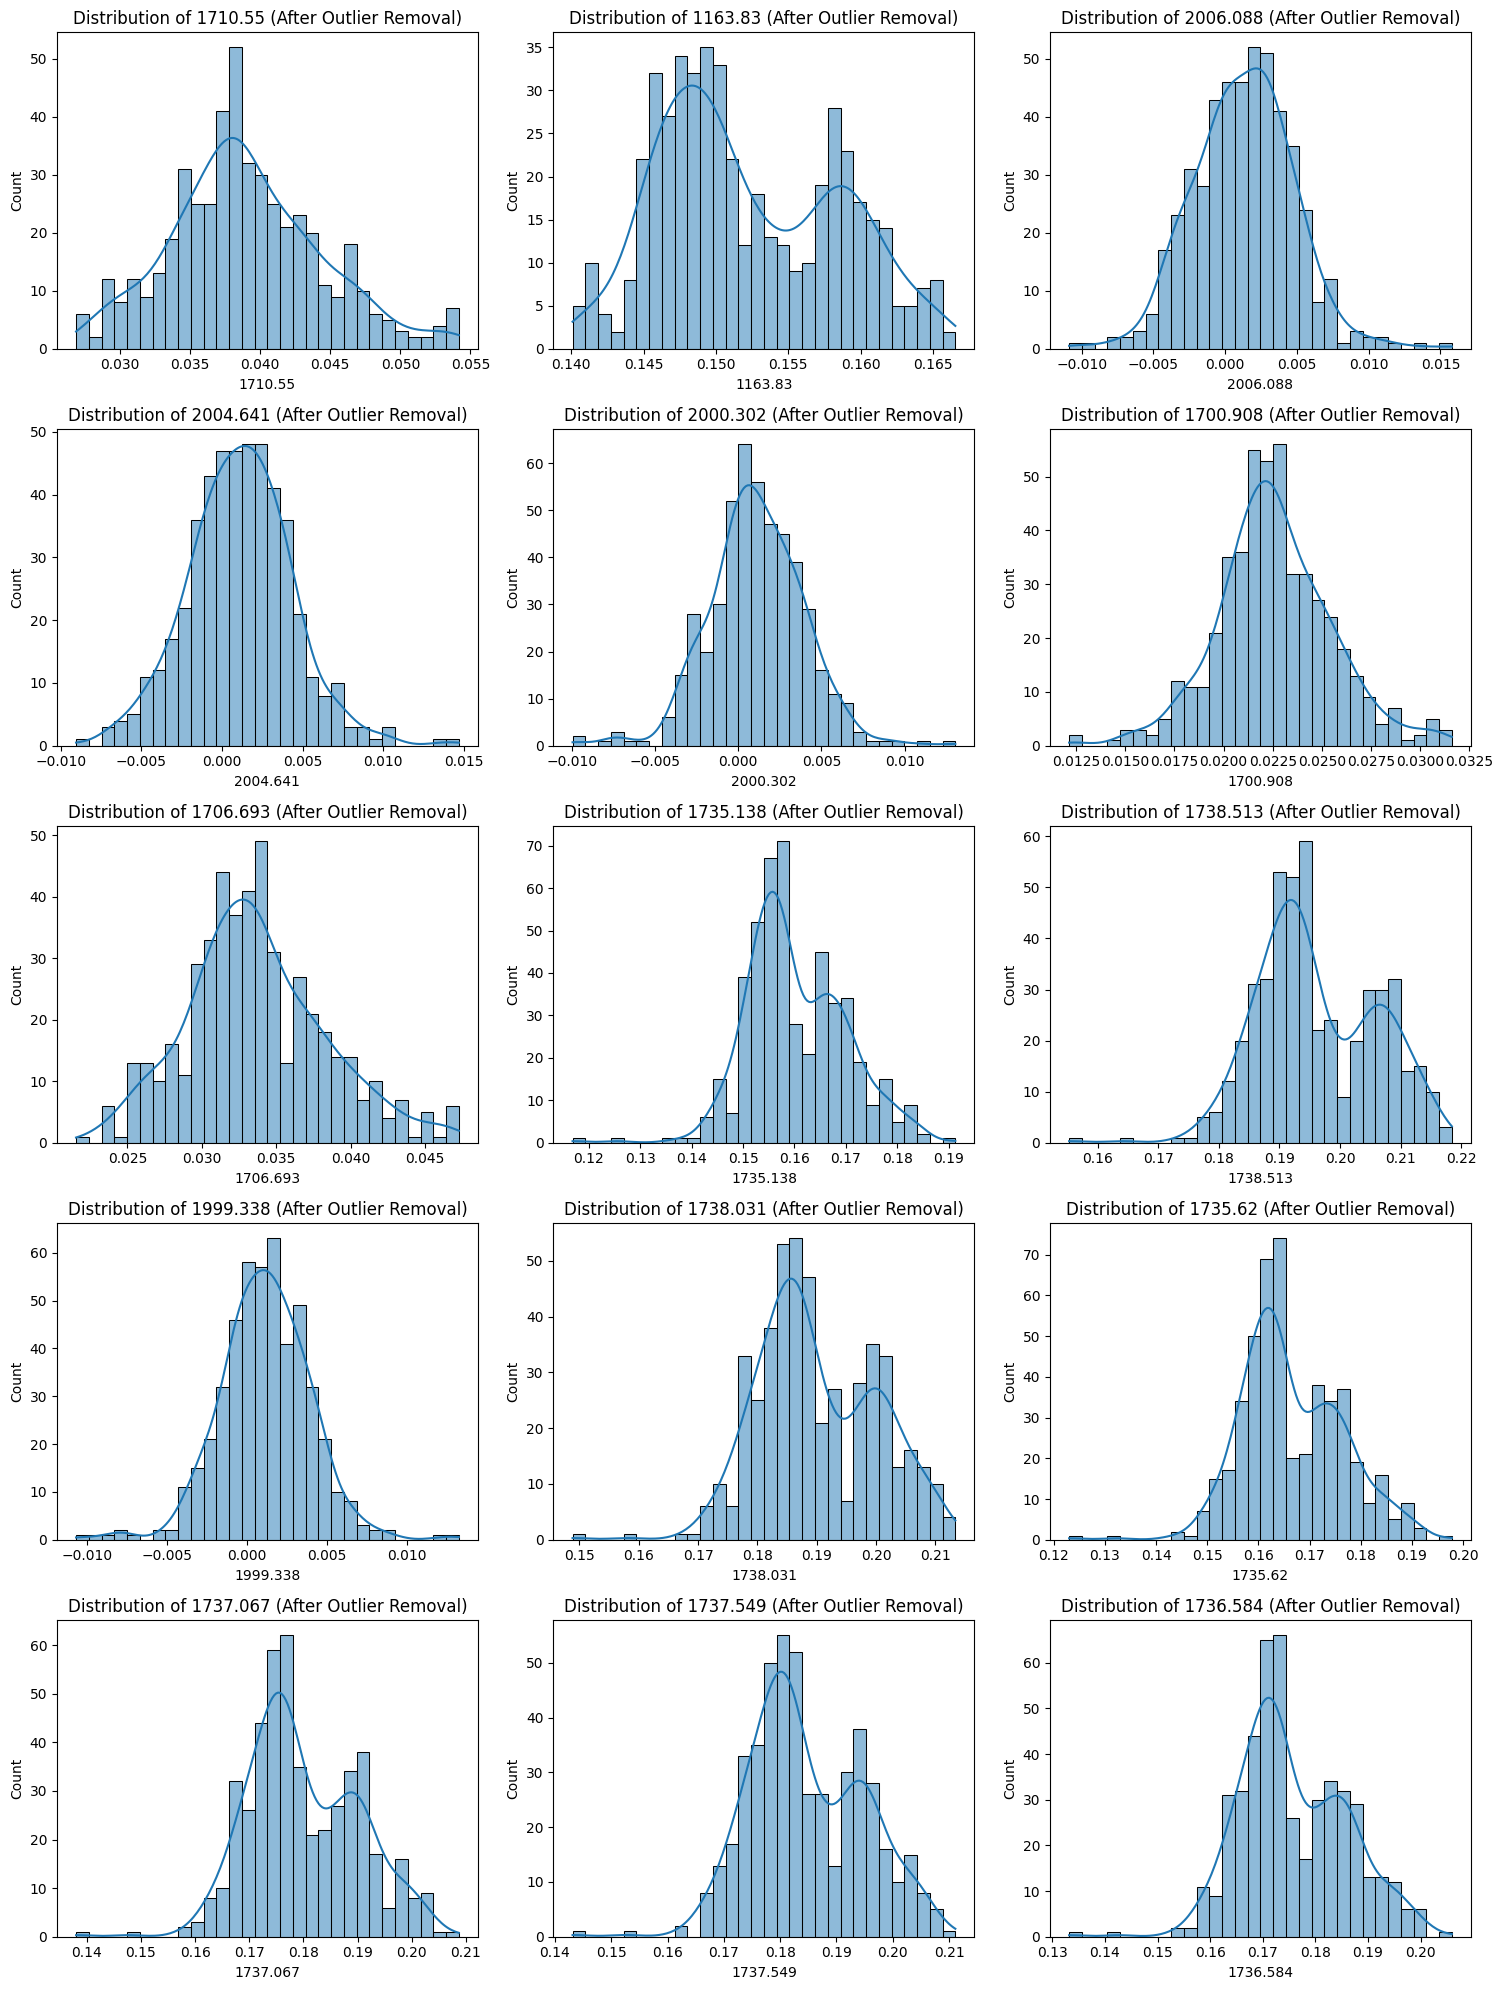

In [3]:
# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 15 important features
top_features = [columns_to_focus[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)

# Plot the distribution of the top 15 most important features after outlier removal
plt.figure(figsize=(15, 20))
for i, feature in enumerate(top_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_0_cleaned[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature} (After Outlier Removal)')
plt.tight_layout()
plt.show()


Initial Data Analysis and Outlier Removal Using Isolation Forest

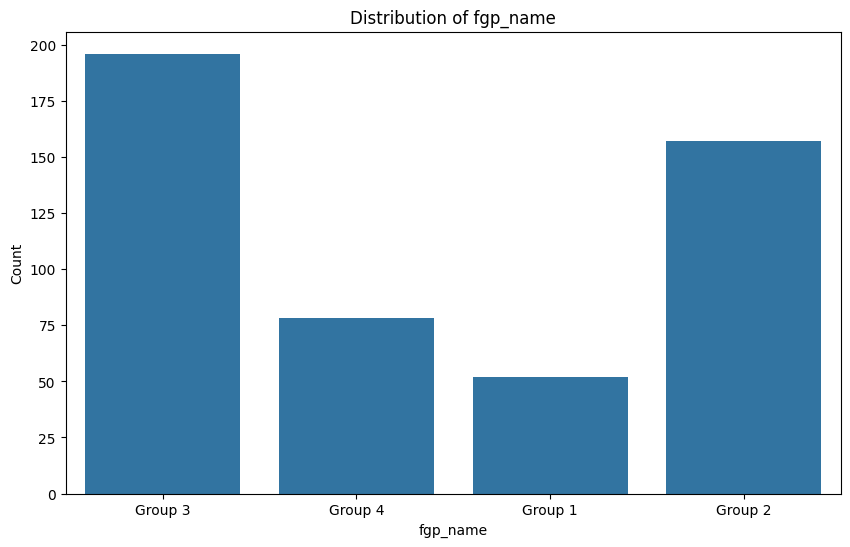

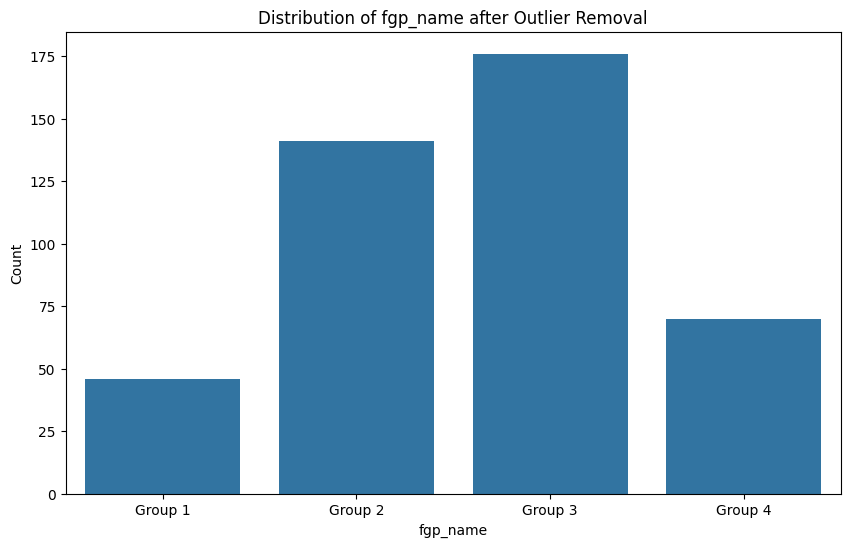

New distribution of fgp_name:
fgp_name
Group 3    176
Group 2    141
Group 4     70
Group 1     46
Name: count, dtype: int64


In [4]:
# Create a distribution plot for 'fgp_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0_cleaned, x=target)
plt.title('Distribution of fgp_name')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()

from sklearn.ensemble import IsolationForest

# Identify and remove outliers in each group using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)

# Separate samples by 'fgp_name'
df_0_cleaned_group_1 = df_0_cleaned[df_0_cleaned[target] == 'Group 1']
df_0_cleaned_group_2 = df_0_cleaned[df_0_cleaned[target] == 'Group 2']
df_0_cleaned_group_3 = df_0_cleaned[df_0_cleaned[target] == 'Group 3']
df_0_cleaned_group_4 = df_0_cleaned[df_0_cleaned[target] == 'Group 4']

# Apply Isolation Forest to each group
def remove_outliers_iso(df, numeric_cols):
    yhat = iso.fit_predict(df[numeric_cols])
    mask = yhat != -1
    return df[mask]

df_0_cleaned_group_1_cleaned = remove_outliers_iso(df_0_cleaned_group_1, numeric_cols_df_0)
df_0_cleaned_group_2_cleaned = remove_outliers_iso(df_0_cleaned_group_2, numeric_cols_df_0)
df_0_cleaned_group_3_cleaned = remove_outliers_iso(df_0_cleaned_group_3, numeric_cols_df_0)
df_0_cleaned_group_4_cleaned = remove_outliers_iso(df_0_cleaned_group_4, numeric_cols_df_0)

# Combine cleaned groups
df_1_cleaned = pd.concat([df_0_cleaned_group_1_cleaned, df_0_cleaned_group_2_cleaned, df_0_cleaned_group_3_cleaned, df_0_cleaned_group_4_cleaned], axis=0).reset_index(drop=True)

# Plot the distribution of fgp_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of fgp_name after Outlier Removal')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()

# Verify the new distribution
print("New distribution of fgp_name:")
print(df_1_cleaned[target].value_counts())


Encode the Target Variable and Balance the Dataset

fgp_name
Group 1    46
Group 2    46
Group 3    46
Group 4    46
Name: count, dtype: int64


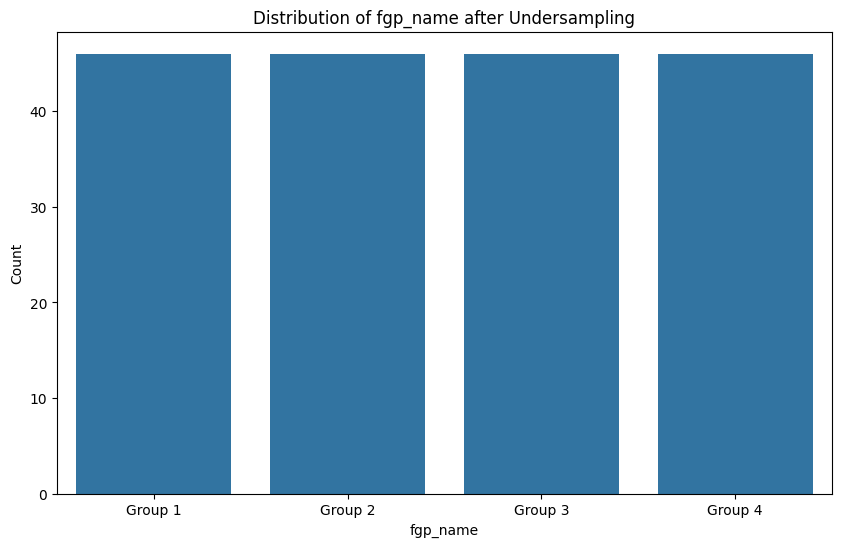

In [5]:
df_2 = df_1_cleaned.copy()

from sklearn.preprocessing import LabelEncoder

# Encoding the 'fgp_name' column
le = LabelEncoder()
df_2['fgp_name_encoded'] = le.fit_transform(df_2['fgp_name'])

# Define the target variable and numeric columns
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

# Train a RandomForest model to get feature importances
X_df_2 = df_2[numeric_cols_df_2].drop(columns=['fgp_name_encoded'])
y_df_2 = df_2['fgp_name_encoded'].values

# Initial model training to find consistent samples
rf = RandomForestClassifier(random_state=42)
rf.fit(X_df_2, y_df_2)

# Get predictions
df_2['predictions'] = rf.predict(X_df_2)

# Keep samples that are correctly classified
consistent_samples = df_2[df_2['fgp_name_encoded'] == df_2['predictions']]

# Separate features and target again with consistent samples
X_df_2_consistent = consistent_samples.drop(columns=['fgp_name', 'fgp_name_encoded', 'predictions'])
y_df_2_consistent = consistent_samples['fgp_name_encoded'].values

# Ensure X_df_2_consistent contains only numeric columns
X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# Determine the size of the smallest group
min_size = consistent_samples['fgp_name'].value_counts().min()

# Map for original string labels to numeric encoded labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Apply undersampling to achieve a balanced dataset
from imblearn.under_sampling import RandomUnderSampler

# Create the sampling strategy dictionary
sampling_strategy = {label_mapping[key]: min_size for key in label_mapping}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# Display the new distribution of 'fgp_name'
balanced_df = consistent_samples.iloc[rus.sample_indices_]
fgp_name_distribution = balanced_df['fgp_name'].value_counts()
print(fgp_name_distribution)

# Check the distribution of 'fgp_name' after undersampling
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='fgp_name')
plt.title('Distribution of fgp_name after Undersampling')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()


Cross-Validation and Evaluation

Mean Accuracy: 0.29145057840710015
Left out group: ['BBX'], Accuracy: 0.4
Left out group: ['CBI'], Accuracy: 0.45454545454545453
Left out group: ['CCO'], Accuracy: 0.07692307692307693
Left out group: ['CPN'], Accuracy: 0.6363636363636364
Left out group: ['KBI'], Accuracy: 0.6153846153846154
Left out group: ['KBX'], Accuracy: 0.0
Left out group: ['KRI'], Accuracy: 1.0
Left out group: ['KTX'], Accuracy: 0.0
Left out group: ['NRT'], Accuracy: 0.5
Left out group: ['NWT'], Accuracy: 0.2
Left out group: ['PKN'], Accuracy: 0.6153846153846154
Left out group: ['PLG'], Accuracy: 0.3333333333333333
Left out group: ['PNA'], Accuracy: 0.0
Left out group: ['PTN'], Accuracy: 0.0
Left out group: ['RIX'], Accuracy: 0.0
Left out group: ['RNG'], Accuracy: 0.1
Left out group: ['SKM'], Accuracy: 0.0
Left out group: ['SNI'], Accuracy: 0.23809523809523808
Left out group: ['SNK'], Accuracy: 0.4
Left out group: ['SSX'], Accuracy: 0.5
Left out group: ['STN'], Accuracy: 0.3333333333333333
Left out group: ['SUX']

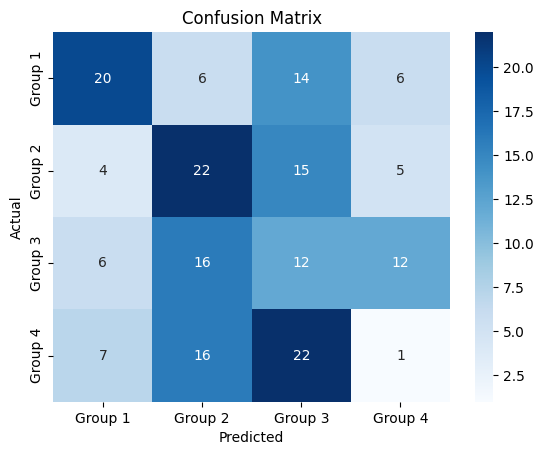

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

# Initialize and encode the 'prov_char' column
le_prov = LabelEncoder()
prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# Define features and target for the balanced dataset
X_balanced = balanced_df.drop(columns=['fgp_name', 'fgp_name_encoded'])
y_balanced = balanced_df['fgp_name_encoded'].values

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    accuracies.append(accuracy)
    left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Final Cleanup and Save

In [ ]:
balanced_df.reset_index(drop=True, inplace=True)

# Rename the column 'wavenumber' to 'sample_code'
data_1 = balanced_df.rename(columns={'wavenumber': 'sample_code'})

data_1 = balanced_df.drop(columns=['fgp_name_encoded', 'predictions'], inplace=True)

In [11]:
data_1.drop(columns=['country_char'], inplace=True)

data_1['sample_code'] = data_1['sample_code'].str[:19]

In [ ]:
#data_1.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asikrt4_4g1_clnd_blncd.csv", index=False)